<a href="https://colab.research.google.com/github/Kususumu/DPMM/blob/master/DPMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In this Notebook
# We test the DPGMM and Compare to K-Means Method
# We plot the result With PCA 2D
import numpy as np
import sklearn
from sklearn import mixture
from matplotlib import pyplot as plt
import scipy.stats as sp
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.ticker import FixedLocator, LinearLocator, FormatStrFormatter
from matplotlib import cm
import pandas as pd
from sklearn.metrics import silhouette_score
import scipy
from sklearn.cluster import KMeans
import pymc3 as pm
from theano import tensor as tt
import theano

# Define A Function to get the covariance
def  genCov(dim):
  """
  Args:
    dim: The number of random covarience
  Returns:
    Covarience

  """
  a = 2
  A = np.matrix([np.random.randn(dim) +
                 np.random.randn(1)*a for i in range(dim)])
  A = A * np.transpose(A)
  D_half = np.diag(np.diag(A) ** (-0.5))
  C = D_half * A * D_half
  sigma = np.diag(np.random.uniform(low = 0,high = 5,size = (dim)))
  return np.dot(np.dot(sigma,C),sigma)

# Generate the Test Data
dim = 20
N = 10000

# Number of clusters
#print(n_clusters)
n_clusters = np.random.choice(range(5,10))

# Sample random mixing proportions
#print(list(1 for x in range(n_clusters)))
#print(mix_prop)
mix_prop = np.random.dirichlet([1 for x in range(n_clusters)])

# Initialize random covariance matrices
covs = [genCov(dim) for x in range(n_clusters)]

# Initialise random mean vectors
means = [np.random.uniform(low = 1,high = 20,size = dim) for x in range(n_clusters)]

# Sample assignments
assign = np.random.multinomial(10000,mix_prop)
assignments = np.repeat(range(n_clusters),assign)
print("assign")
print(assign)

# Generate Data
mix = np.vstack([sp.multivariate_normal.rvs(mean = m,cov = c,size = g) for
                 m,c,g in zip(means,covs,assign)])

"""
# Generate 400 data from 4 center
X, y_true = make_blobs(n_samples=500, centers=4,
                       cluster_std=0.60, random_state=0)

# Use ::-1 to Inverse the Feature
X = X[:,::-1] 

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Samples from a GMM with 4 components')
plt.show()
"""

assign
[2390  374 1167   28 2553 3488]


"\n# Generate 400 data from 4 center\nX, y_true = make_blobs(n_samples=500, centers=4,\n                       cluster_std=0.60, random_state=0)\n\n# Use ::-1 to Inverse the Feature\nX = X[:,::-1] \n\nkmeans = KMeans(4, random_state=0)\nlabels = kmeans.fit(X).predict(X)\nplt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.title('Samples from a GMM with 4 components')\nplt.show()\n"

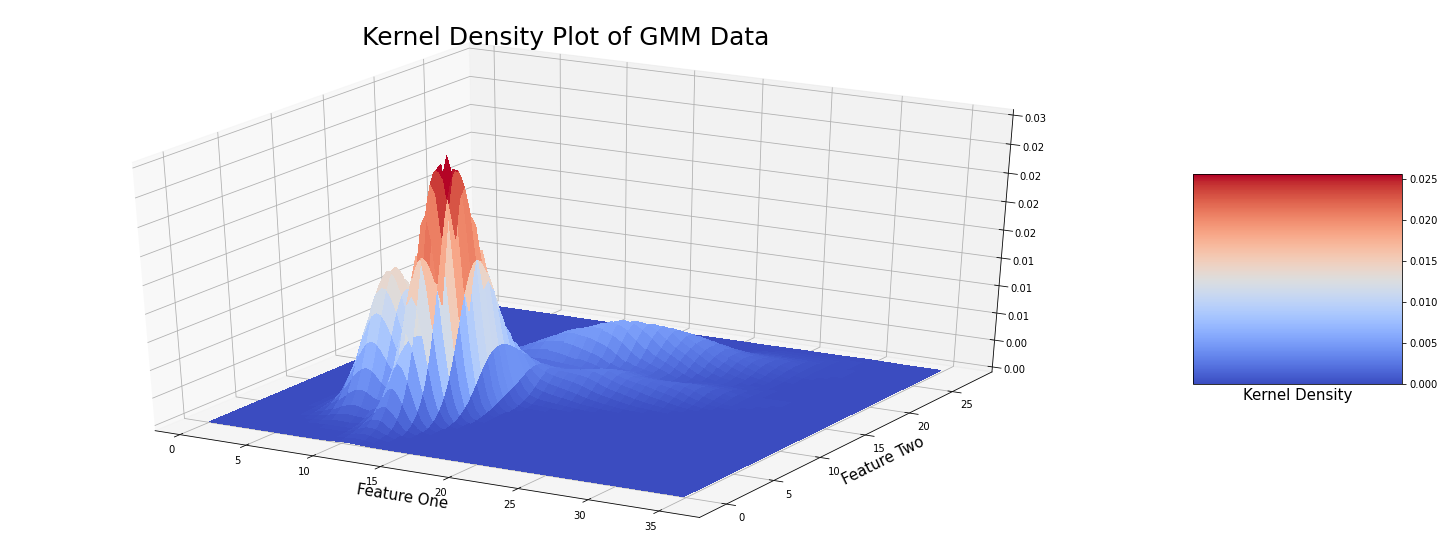

In [ ]:
# Using Kernel Density Function to estimate the parameter
# Gaussian Kernel density function
x = mix[:,0]
y = mix[:,1]
xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)
xx,yy = np.mgrid[xmin:xmax:100j,ymin:ymax:100j]
postions = np.vstack([xx.ravel(),yy.ravel()])
values = np.vstack([x,y])
kernel = sp.gaussian_kde(values)
f = np.reshape(kernel(postions).T,xx.shape)

# Plot the result
fig = plt.figure(figsize=(25,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx,yy,f,cmap=cm.coolwarm,linewidth=0,antialiased=False)

# Customize the z axis
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors
mate = fig.colorbar(surf,shrink=0.5,aspect=1)
mate.ax.set_xlabel('Kernel Density',fontsize=15)
plt.xlabel('Feature One',fontsize=15)
plt.ylabel('Feature Two',fontsize=15)
plt.title('Kernel Density Plot of GMM Data',fontsize=25)
plt.show()


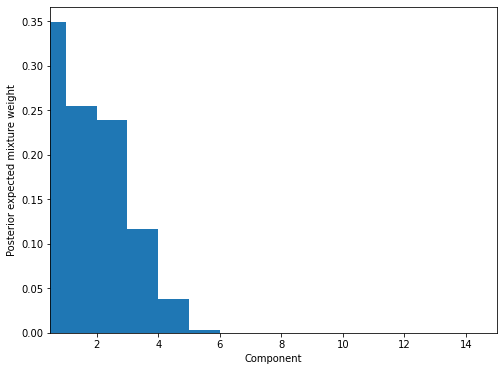

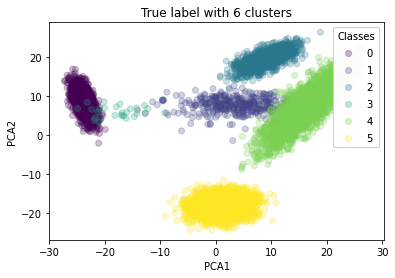

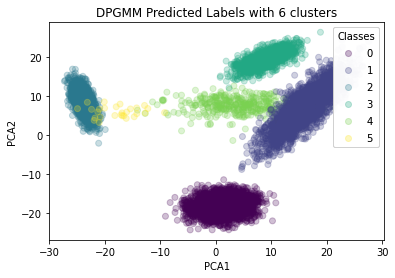

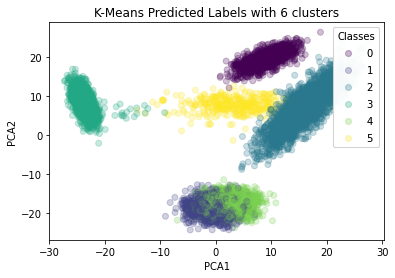

In [ ]:
# DPGMM Model
DPGMM = mixture.BayesianGaussianMixture(n_components=15, 
                          max_iter=100000000,
                          n_init=10,
                          tol=1e-5, 
                          init_params='kmeans', 
                          weight_concentration_prior_type='dirichlet_process',
                          weight_concentration_prior=1/10)
DPGMM.fit(mix)

# Get the active number of results
#print("DPGMM.weights_")
#print(DPGMM.weights_)
#print("active_num")
#print(active_num)
active_num = 0
for i in DPGMM.weights_:
  if i > 0.001:
    active_num = active_num + 1 
  
# Plot the model
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(15) + 1

ax.bar(plot_w - 0.5, np.sort(DPGMM.weights_)[::-1], width=1., lw=0);

ax.set_xlim(0.5, 15);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

### True Labels
# Plot With PCA With True Labels
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
X = pca.fit_transform(mix)
fig, ax = plt.subplots()


scatter = ax.scatter(X[:, 0], X[:, 1], c=assignments, cmap=plt.cm.viridis, alpha=.25);
plt.title("True label with %s clusters" %len(np.unique(assignments)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


### Predict Labels With DPGMM
# Set the x.xxxxxx
eps = 1e-16
w = (-DPGMM.weights_).argsort()[:active_num]
mat = []
for ind2 in w:
    p1 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
    mat.append(p1)
clusts = pd.DataFrame(mat).T.idxmax(axis=1)

# Plot With PCA With DPGMM Labels
fig, ax = plt.subplots()

scatter = ax.scatter(X[:, 0], X[:, 1], c=clusts, cmap=plt.cm.viridis, alpha=.25);
plt.title("DPGMM Predicted Labels with %s clusters" %len(np.unique(clusts)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

### Predict Labels With K-Means
n_clust = active_num
clusterer = KMeans(n_clusters=n_clust, random_state=10)
cluster_labels = clusterer.fit_predict(mix)

# Plot
fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=plt.cm.viridis, alpha=.25);
plt.title("K-Means Predicted Labels with %s clusters" %len(np.unique(cluster_labels)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
